# Results on the QM9 dataset

In [31]:
import pubchempy as pcp
import seaborn as sns

from tqdm import tqdm
from rdkit import RDLogger

from rdkit import Chem
from rdkit.Chem import Crippen, QED
from rdkit.Chem import RDConfig

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import sascorer

# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
vae = VAEUtils(directory='../models/qm9')
vae_properties = VAEUtils(directory='../models/qm9_properties')

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:432: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3535: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:113: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1210: calling reduce_prod_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2878: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
From /home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:154: The name tf.get_default_

Using standarized functions? True
Standarization: estimating mu and std values ...done!


/home/sven/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!


### Evaluate Generative Model Metrics
- Validity
- Uniqueness
- Novelty

In [8]:
def eval_model(model):
    dataset_smiles = vae.random_molecules()
    dataset_smiles = set(dataset_smiles)

    z = np.random.randn(10000, 156)
    x = model.decode(z)

    gen_smiles = vae.hot_to_smiles(x, strip=True)
    valid_count = 0
    novel_count = 0

    valid_smiles = set()

    for smiles in gen_smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1
            valid_smiles.add(smiles)
            if smiles not in dataset_smiles:
                novel_count += 1

    print(f"Validity = {valid_count / len(gen_smiles)}")
    print(f"Uniqueness = {len(valid_smiles) / valid_count}")
    print(f"Novelty = {novel_count / len(valid_smiles)}")

print("Generative Model Metrics without property prediction:")
eval_model(vae)
print("Generative Model Metrics with property prediction:")
eval_model(vae_properties)

Generative Model Metrics without property prediction:
Validity = 0.0542
Uniqueness = 0.9981549815498155
Novelty = 0.966728280961183
Generative Model Metrics with property prediction:
Validity = 0.0928
Uniqueness = 0.9924568965517241
Novelty = 0.9120521172638436


### Figure 2: Representations of the sampling results from the variational autoencoder

a) Kernel Density Estimation (KDE) of each latent dimension of the autoencoder, i.e., the distribution of encoded molecules along each dimension of our latent space representation

![](../aux_data/fig2a.PNG)


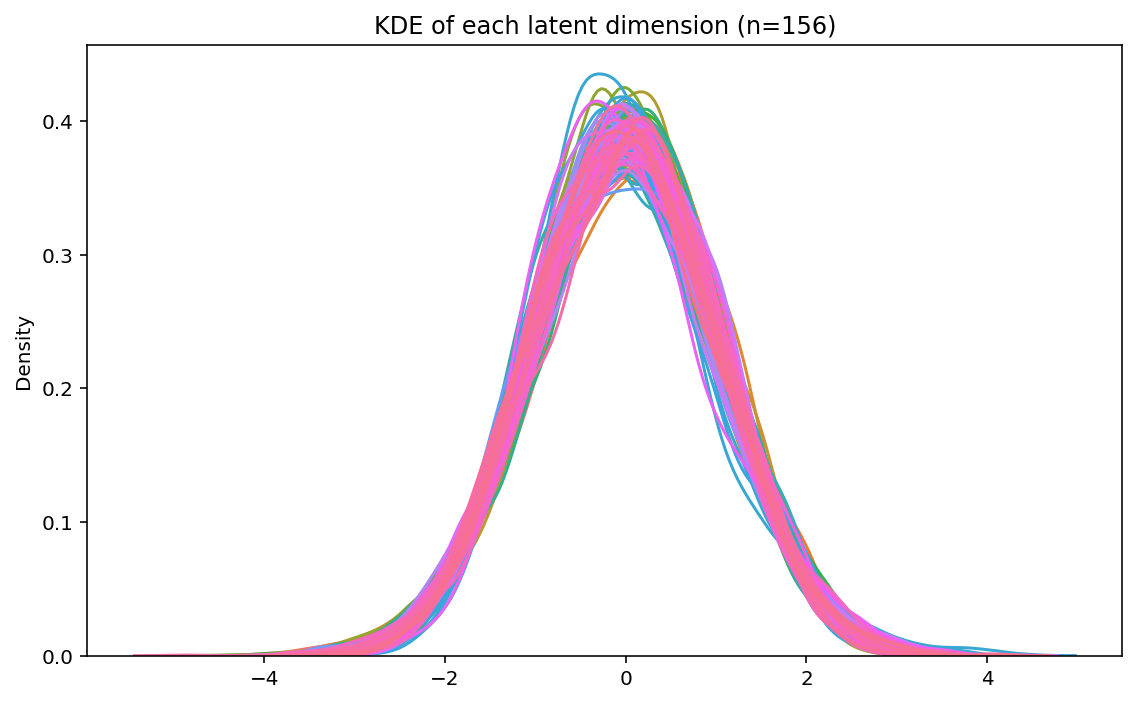

In [5]:
# encode 5000 random molecules and plot a kernel density estimate of their latent representation
# to show that the latent variables follow a gaussian distribution

rand_5000_molecules = vae.random_molecules(size=5000)
X_rand_5000_molecules = vae.smiles_to_hot(rand_5000_molecules,canonize_smiles=True)
z_rand_5000_molecules = vae.encode(X_rand_5000_molecules)

# Set up the plotting environment
plt.figure(figsize=(8, 5))

# For each dimension in the data, compute and plot the KDE
for dim in range(z_rand_5000_molecules.shape[1]):
    sns.kdeplot(z_rand_5000_molecules[:, dim], legend=False, color=sns.color_palette("husl", 156)[dim])

plt.title('KDE of each latent dimension (n=156)')
plt.tight_layout()
plt.show()

b) histogram of sampled
molecules for a single point in the latent space; the distances of the molecules from the original query are shown by the lines corresponding to the right axis


![](../aux_data/fig2b.PNG)

CCc1ncc(N)nn1


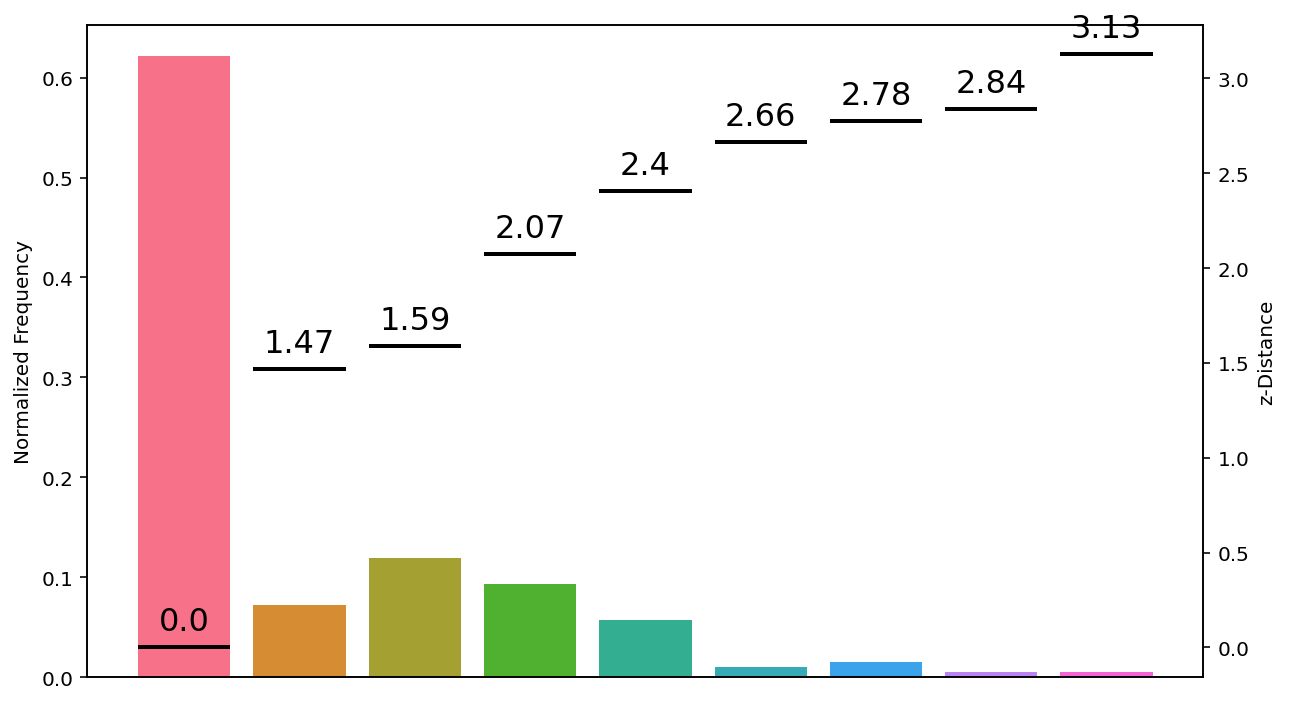

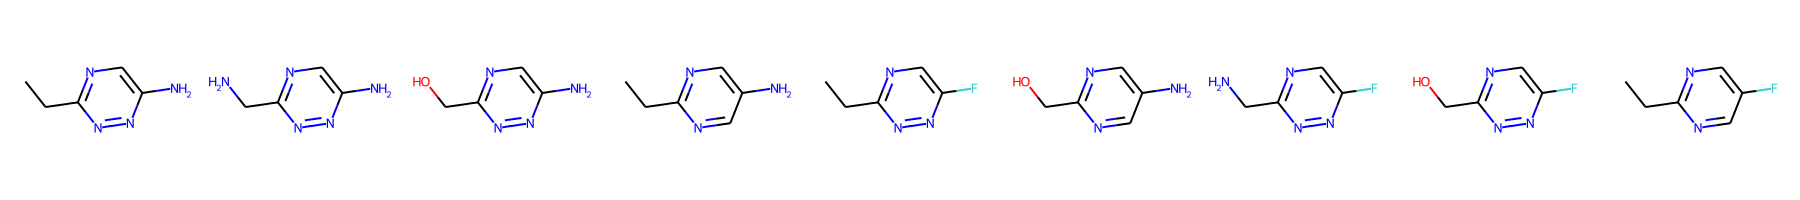

In [64]:
# pick and random molecule from the dataset
molecule = vae.random_molecules(size=1)[0]
print(molecule)
X = vae.smiles_to_hot(molecule,canonize_smiles=True)
z = vae.encode(X)

decode_attempts = 200

Z = np.tile(z, (decode_attempts, 1))
X = vae.decode(Z)
smiles = vae.hot_to_smiles(X, strip=True)
df = vae.prep_mol_df(smiles, z)

# plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
colors = sns.color_palette("husl", len(df))
bars = ax1.bar(df.index, df['frequency'] / df['frequency'].sum(), label='Frequency', color=colors)

for bar, distance in zip(bars, df['distance']):
    ax2.hlines(distance, bar.get_x(), bar.get_x() + bar.get_width(), colors='black', linewidth=2)
    rounded_distance = round(distance, 2)
    ax2.annotate(str(rounded_distance),
                 (bar.get_x() + bar.get_width()/2, distance),
                 textcoords="offset points",
                 xytext=(0,5),  # 5 points vertical offset
                 ha='center',
                 va='bottom',
                 fontsize=16,
                 color='black')

ax2.set_ylabel('z-Distance')
ax1.set_ylabel('Normalized Frequency')

plt.xticks(ticks=[])
plt.show()

display(PandasTools.FrameToGridImage(df,column='mol' , molsPerRow=len(df)))

c) molecules sampled near the location of ibuprofen in latent space. The values below the molecules are the distance in latent space from
the decoded molecule to ibuprofen

![](../aux_data/fig2c.PNG)

Searching molecules randomly sampled from 40.00 std (z-distance) from the point


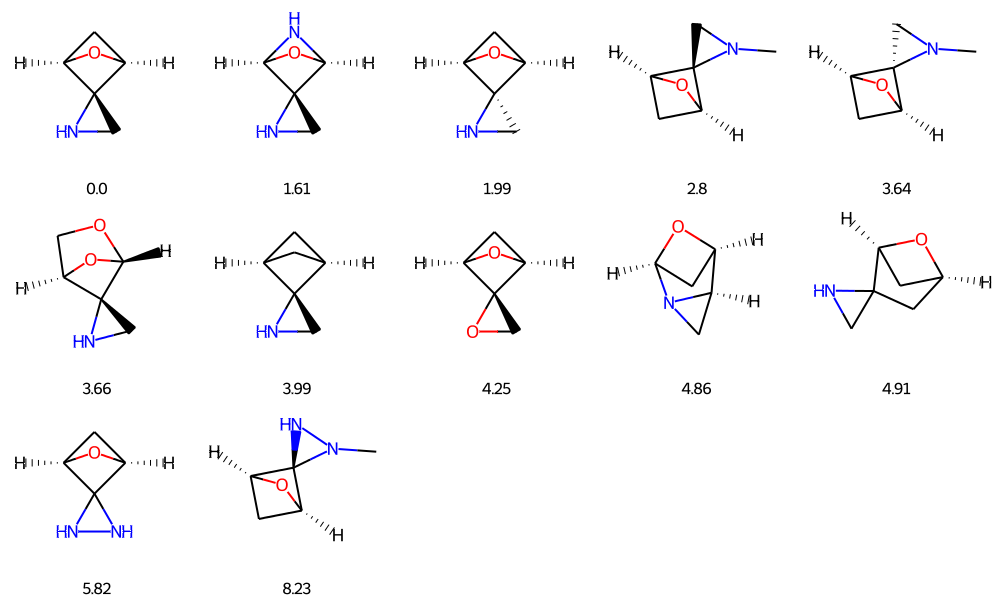

In [74]:
smiles_1 = vae.random_molecules(size=1)

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)

noise=40.0
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles(z_1, decode_attempts=2000,noise_norm=noise)
# print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
# print('SMILES\n',df.smiles)
df.sort_values(by="distance", inplace=True)
df = df.round({"distance": 2})
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='distance',molsPerRow=5))
# df.head()

d) slerp interpolation between two molecules in latent space using six steps of equal distance

![](../aux_data/fig2d.PNG)

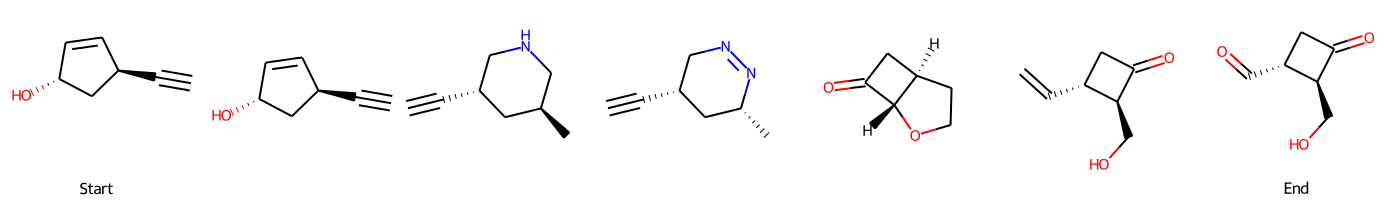

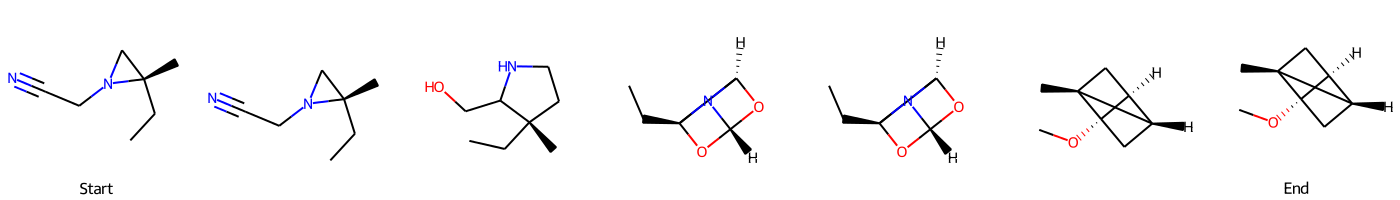

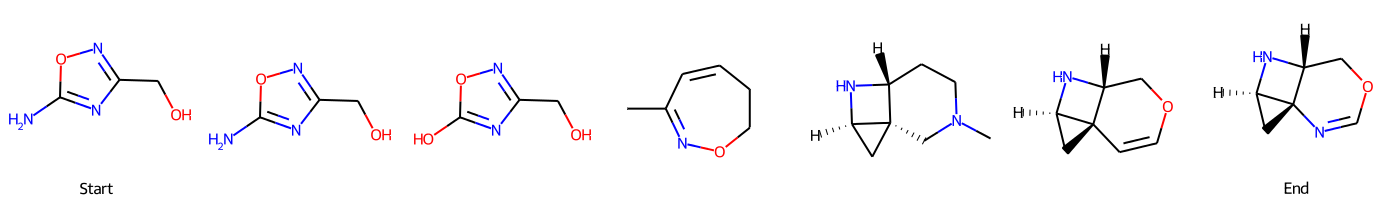

In [80]:
def plot_latent_slerp(start_smiles: str, end_smiles):
    molecule_smiles = [start_smiles, end_smiles]

    slerp_df = pd.DataFrame({'smiles': molecule_smiles, "slerp": [0.0, 1.0], "name": ["Start", "End"]})
    slerp_df["mol"] = slerp_df['smiles'].apply(mu.smiles_to_mol)

    X_mols = vae.smiles_to_hot(molecule_smiles,canonize_smiles=True)
    z_mols = vae.encode(X_mols)

    from scipy.spatial import geometric_slerp

    for i in range(1, 6):
        fraction = i / 7.0

        decode_attempts = 500

        sphere_center = 0.5 * z_mols[0] + 0.5 * z_mols[1]

        start_mol_z = z_mols[0] - sphere_center
        end_mol_z = z_mols[1] - sphere_center

        norm_scale = np.linalg.norm(start_mol_z)
        assert np.linalg.norm(start_mol_z) - np.linalg.norm(end_mol_z) < 0.0001

        start_mol_z /= norm_scale
        end_mol_z /= norm_scale

        z_slerped = geometric_slerp(start_mol_z, end_mol_z, fraction)
        z_slerped = z_slerped * norm_scale + sphere_center

        Z = np.tile(z_slerped, (decode_attempts, 1))
        X = vae.decode(Z)
        smiles = vae.hot_to_smiles(X, strip=True)
        df = vae.prep_mol_df(smiles, z_slerped)
        if len(df) == 0:
            print(f"Could not decode a valid molecule after {decode_attempts} attempts.")
            continue
        clostest_mol = df.iloc[0]
        # print(clostest_mol)
        slerp_df = slerp_df.append({"smiles": clostest_mol["smiles"], "slerp": fraction, "name": "", "mol": clostest_mol["mol"]}, ignore_index=True)

    slerp_df = slerp_df.sort_values("slerp")
    # print(slerp_df)
    display(PandasTools.FrameToGridImage(slerp_df, column='mol', legendsCol="name", molsPerRow=7))

# plot interpolation between 3 random molecule pairs
plot_latent_slerp(vae.random_molecules(size=1)[0], vae.random_molecules(size=1)[0])
plot_latent_slerp(vae.random_molecules(size=1)[0], vae.random_molecules(size=1)[0])
plot_latent_slerp(vae.random_molecules(size=1)[0], vae.random_molecules(size=1)[0])

### Figure 3: Representations of the sampling results from the variational autoencoder

![](../aux_data/fig3qm9.PNG)

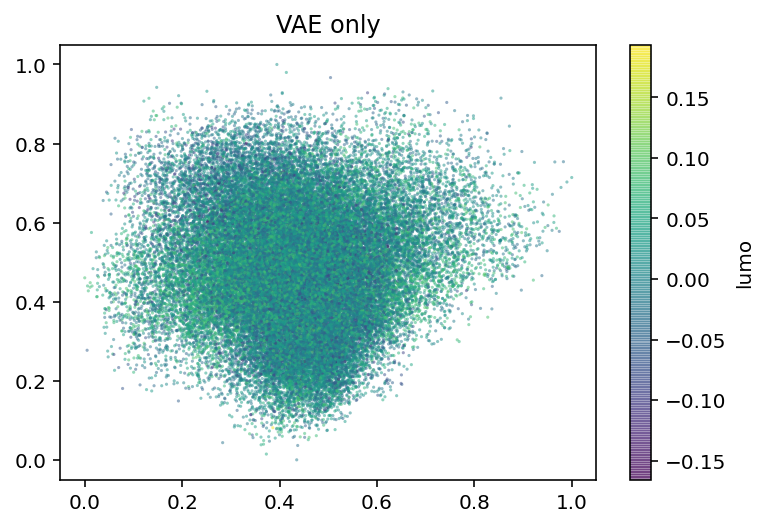

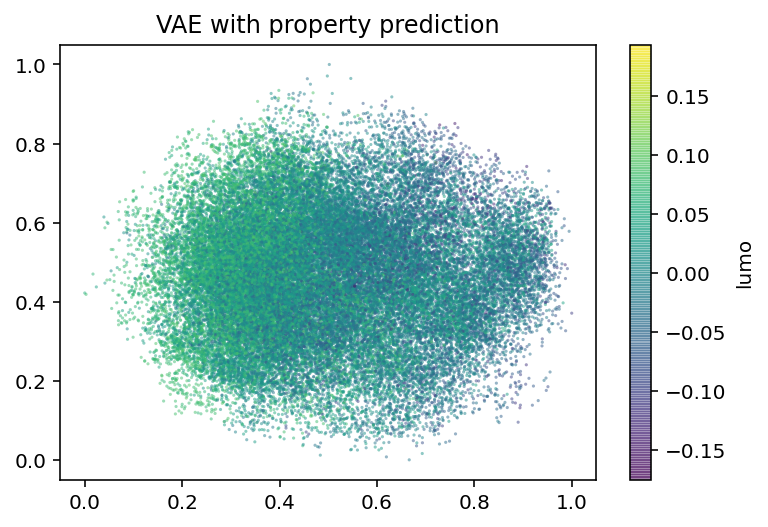

In [8]:
def pca_latent_vis(vae_model, prop_opt, title):
    Z, data, smiles = vae_model.ls_sampler_w_prop(size=50000,return_smiles=True)
    prop_df = pd.DataFrame(data).reset_index()
    prop_df['smiles']=smiles

    from sklearn.decomposition import PCA
    from sklearn.preprocessing import MinMaxScaler

    # do pca and normalize
    Z_pca = PCA(n_components=2).fit_transform(Z)
    Z_pca = MinMaxScaler().fit_transform(Z_pca)

    df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
    df.columns = ['x','y']
    df[prop_opt]=prop_df[prop_opt]

    scatter = plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    plt.colorbar(scatter, label=prop_opt)
    plt.title(title)
    plt.show()
    
pca_latent_vis(vae, "lumo", "VAE only")
pca_latent_vis(vae_properties, "lumo", "VAE with property prediction")

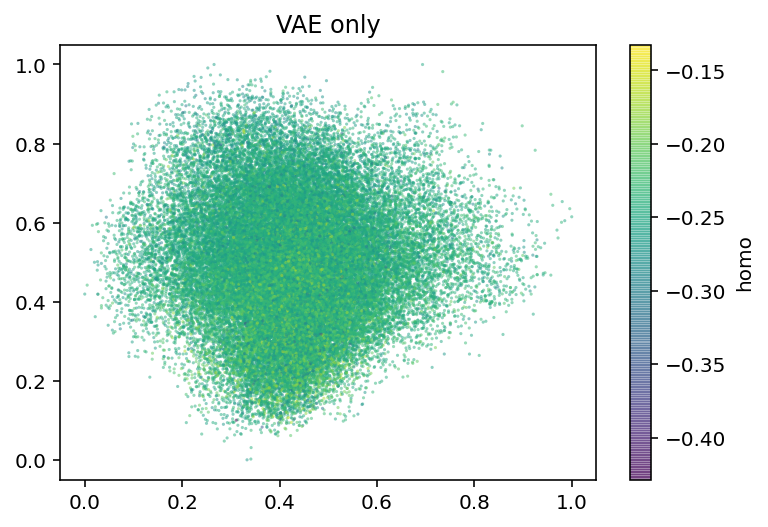

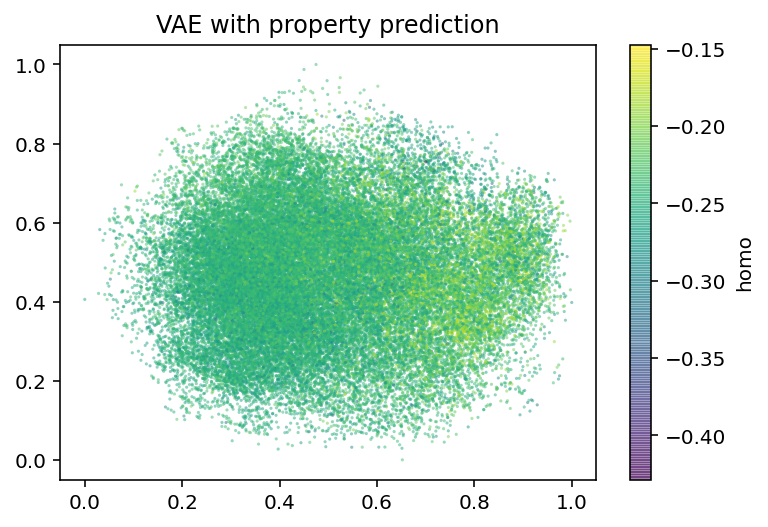

In [9]:
pca_latent_vis(vae, "homo", "VAE only")
pca_latent_vis(vae_properties, "homo", "VAE with property prediction")

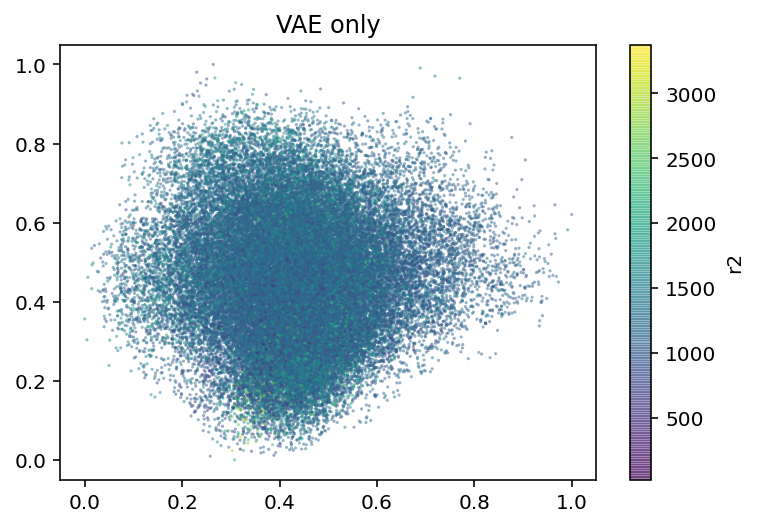

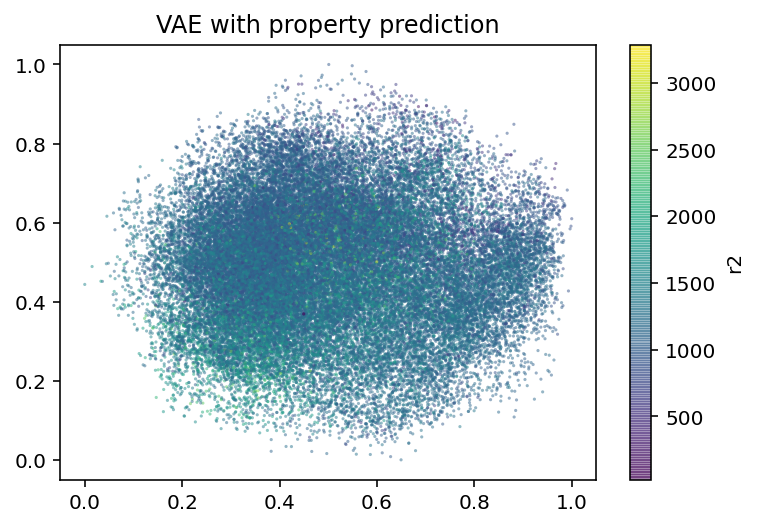

In [10]:
pca_latent_vis(vae, "r2", "VAE only")
pca_latent_vis(vae_properties, "r2", "VAE with property prediction")

### Table 1: Comparison of Molecule Generation Results to Original Datasets

![](../aux_data/tab1qm9.PNG)

In [15]:
# generate random by encoding 100 random molecules and decoding them 400 times
seed_size = 100

Z, _ = vae.ls_sampler_w_prop(size=seed_size)
generated_smiles = set()
for i in tqdm(range(Z.shape[0])):
    z = Z[i,:]
    decode_attempts = 400
    Z_tiled = np.tile(z, (decode_attempts, 1))
    X = vae.decode(Z_tiled)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z)

    generated_smiles.update(df["smiles"])

# generate molecules by decoding random gaussian noise
Z = np.random.normal(0, 1, (1000, 156))
generated_smiles_random = set()
for i in tqdm(range(Z.shape[0])):
    z = Z[i,:]
    decode_attempts = 100
    Z_tiled = np.tile(z, (decode_attempts, 1))
    X = vae.decode(Z_tiled)
    smiles = vae.hot_to_smiles(X, strip=True)
    df = vae.prep_mol_df(smiles, z)

    generated_smiles_random.update(df["smiles"])

# compute qed, logp and SAS for the whole dataset
dataset_smiles = vae.random_molecules()

logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in tqdm(dataset_smiles):
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"QM9 samples = {len(dataset_smiles)}")
logP_np = np.array(logP_vals)
print(f"QM9 logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"QM9 SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"QM9 QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")
print("-------------------------------------")


# VAE (encode-decode) generated dataset property stats
logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in tqdm(generated_smiles):
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"VAE (encode-decode) samples = {len(generated_smiles)}")
logP_np = np.array(logP_vals)
print(f"VAE (encode-decode) logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"VAE (encode-decode) SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"VAE (encode-decode) QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")
print("-------------------------------------")

# VAE (random) generated dataset property stats
logP_vals = []
qed_vals = []
sas_vals = []
for mol_smiles in tqdm(generated_smiles_random):
    mol = Chem.MolFromSmiles(mol_smiles)
    logP_vals.append(Crippen.MolLogP(mol))
    try:
        qed_vals.append(QED.qed(mol))
    except:
        pass
    sas_vals.append(sascorer.calculateScore(mol))

print(f"VAE (random) samples = {len(generated_smiles_random)}")
logP_np = np.array(logP_vals)
print(f"VAE (random) logP mean(std) = {logP_np.mean():.2f}({logP_np.std():.2f})")

sas_np = np.array(sas_vals)
print(f"VAE (random) SAS mean(std) = {sas_np.mean():.2f}({sas_np.std():.2f})")

qed_np = np.array(qed_vals)
print(f"VAE (random) QED mean(std) = {qed_np.mean():.2f}({qed_np.std():.2f})")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 123102/123102 [03:53<00:00, 528.21it/s]


QM9 samples = 123102
QM9 logP mean(std) = 0.33(0.95)
QM9 SAS mean(std) = 4.20(0.92)
QM9 QED mean(std) = 0.47(0.07)
-------------------------------------


100%|██████████| 1239/1239 [00:02<00:00, 516.97it/s]


VAE (encode-decode) samples = 1239
VAE (encode-decode) logP mean(std) = 0.21(0.97)
VAE (encode-decode) SAS mean(std) = 4.33(0.92)
VAE (encode-decode) QED mean(std) = 0.48(0.07)
-------------------------------------


100%|██████████| 3112/3112 [00:06<00:00, 480.70it/s]

VAE (random) samples = 3112
VAE (random) logP mean(std) = 0.46(0.96)
VAE (random) SAS mean(std) = 4.86(0.91)
VAE (random) QED mean(std) = 0.49(0.07)


### Table 2: MAE Prediction Error for Properties Using Various Methods on the ZINC and QM9 Datasets

![](../aux_data/tab2qm9.PNG)

In [14]:
Z, data = vae_properties.ls_sampler_w_prop(size=50000)
prop_df = pd.DataFrame(data).reset_index()

# important detail
hartree_to_electronvolt_scale = 27.2114

y_homo_mean = prop_df['homo'].to_numpy().mean()
y_lumo_mean = prop_df['lumo'].to_numpy().mean()
y_r2_mean = prop_df['r2'].to_numpy().mean()

print(f"homo Mean MAE (eV) = {(np.abs(y_homo_mean - prop_df['homo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")
print(f"lumo Mean MAE (eV) = {(np.abs(y_lumo_mean - prop_df['lumo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")
print(f"r2 Mean MAE (A^2) = {(np.abs(y_r2_mean - prop_df['r2'].to_numpy())).mean()}")

y_vae = vae_properties.predict_prop_Z(Z, standardized=True)
print(f"homo VAE MAE (eV) = {(np.abs(y_vae[:,0] - prop_df['homo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")
print(f"lumo VAE MAE (eV) = {(np.abs(y_vae[:,1] - prop_df['lumo'].to_numpy())).mean() * hartree_to_electronvolt_scale}")
print(f"r2 VAE MAE (A^2) = {(np.abs(y_vae[:,2] - prop_df['r2'].to_numpy())).mean()}")

homo Mean MAE (eV) = 0.44342783788509754
lumo Mean MAE (eV) = 1.035445536525447
r2 Mean MAE (A^2) = 203.37015571584317
homo VAE MAE (eV) = 0.32011024217726275
lumo VAE MAE (eV) = 0.48220711707889535
r2 VAE MAE (A^2) = 123.66350938906182
